# Procesamiento de Imágenes
Durante el presente módulo, exploraremos las herramientas que ofrece OpenCV para realizar procesamiento general de imágenes, esto incluye operaciones básicas como transformaciones geométricas sobre las imágenes, detección de contornos y bordes y umbralización. A lo largo de este tutorial, desarrollaremos un pequeño juego de Pong basado en detección y extracción de regiones de colores obtenidas a partir de imágenes de la cámara del computador. Abróchense los cinturones y disfruten las transformaciones.

## Extracción de regiones por rango de colores
Hasta el momento, se ha representado una imagen empleando distintos espacios de color, ahora emplearemos esta información para encontrar objetos que comparten un color en una imagen. Según el ejemplo presentado en el módulo previo, las regiones que compartían un mismo color, presentaban un valor de intensidad similar en el espacio HSV.

Con esta información, es posible definir rangos de colores, por ejemplo, es posible definir un rango de colores HSV que representan el color Naranja. En este caso, no es necesario conocer el valor puntual del color en HSV, por el contrario, es posible emplear la función ``cv2.cvtColor`` y la constante ``cv2.COLOR_RGB2HSV``.

**Nota:** El color naranja se encuentra representado por la tripleta RGB $[255, 103, 0]$, también es posible usar un selector de colores para encontrar el color en RGB deseado.

In [1]:
import cv2
import numpy as np
import ipywidgets as widgets
% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display


def hex_to_rgb(hex_color):
    hex_color = hex_color[1:]
    rgb = []
    for i in range(0, len(hex_color), 2):
        rgb.append(int(hex_color[i:i + 2], 16))
    return np.uint8([[rgb]])

w = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='#ff6700'
)
display(w)
print(hex_to_rgb(w.value))

[[[255 103   0]]]


Ahora, convertiremos el color seleccionado en una tripleta HSV:

In [3]:
rgb = hex_to_rgb(w.value)
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
print(hsv)

[[[ 12 255 255]]]


A continuación, cargaremos una imagen a color en la cual aparece el color en cuestión

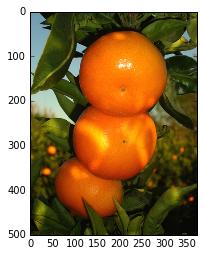

In [4]:
img = mpimg.imread('img/color/oranges.jpg')
plt.imshow(img)
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

OpenCV ofrece la función para filtrar los valores de una imagen por rango, si el valor de intensidad para un pixel en la imagen se encuentra en el rango de colores a filtrar, este es marcado como uno, de lo contrario, es marcado como cero. A continuación se presenta esta funcionalidad:

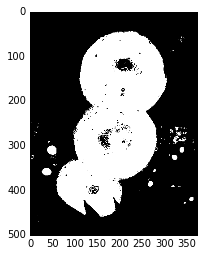

In [5]:
h, s, v = hsv[0, 0]

# La configuración de estos rangos puede hacer que la máscara sea más definida
lower_color = np.array([[[-10 + h, 230, 100]]]) 
upper_color = hsv + np.array([[[0 + h, 255, 255]]])

mask = cv2.inRange(hsv_img, lower_color[:, 0], upper_color[:, 0])
plt.imshow(mask, cmap='gray')

## Operaciones morfológicas

Como es posible observar, la mascara resultante señala las naranjas presente en la imagen, sin embargo, hay mucho ruido presente, esto se debe a que el rango de color escogido también incluye otras regiones, tal como el reflejo óptico de la cámara, así como otras anomalías causadas por la iluminación del entorno. Para eliminar este ruido, existen diferentes operaciones morfológicas sobre la imagen, las cuales permiten eliminar ruido y otros defectos presentes en una máscara. A continuación se presentarán las operaciones morfológicas más importantes:

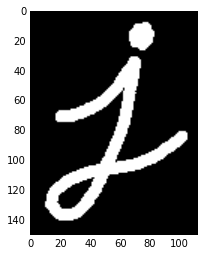

In [6]:
base_img = mpimg.imread('img/morph/original.png')
plt.imshow(base_img)

### Erosión
Esta operación consta de seleccionar los pixeles tales que todos sus vecinos (De acuerdo a una forma), sean 1, si un píxel no cumple con esta condición, se hace cero. Para realizar esta operación, es necesario definir un elemento estructural o forma que establece la relación entre un píxel y sus vecinos, OpenCV ofrece distintos elementos, tales como cruces, elipses y rectángulos, los cuales pueden ser definidos para cubrir un radio de pixeles específicos:

#### Elementos estructurales

In [7]:
# Elemento en forma de cruz de radio 5
cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [8]:
# Elemento en forma de elipse de radio 5
cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

array([[0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [9]:
# Elemento en forma de caja de radio 5
cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

Tras definir un elemento estructural, es posible realizar la dilatación de la imagen presentada

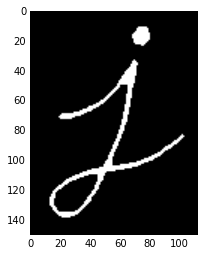

In [10]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
erosion = cv2.erode(base_img, kernel, iterations = 1)
plt.imshow(erosion)

### Dilatación
De forma análoga a la erosión, la dilatación considera a un píxel 1, si al menos un elemento bajo la forma definida es 1. Esto permite agrandar los contornos de una máscara:

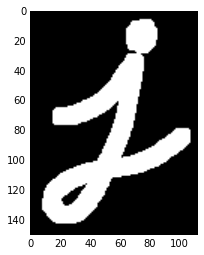

In [11]:
dilation = cv2.dilate(base_img, kernel, iterations=1)
plt.imshow(dilation)

### Apertura
La apertura de una imagen, corresponde a una erosión, seguida de una dilatación. Esta operación es útil para eliminar ruido que se encuentra en el exterior de una región. OpenCV permite realizar ambas operaciones empleando la función ``cv2.morphologyEx``:

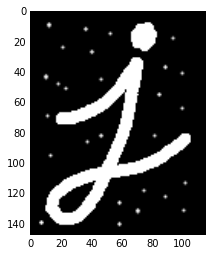

In [12]:
to_open = mpimg.imread('img/morph/opening.png')
plt.imshow(to_open)

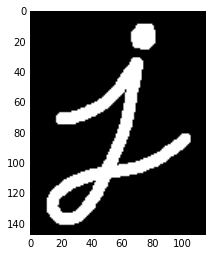

In [13]:
opening = cv2.morphologyEx(to_open, cv2.MORPH_OPEN, kernel)
plt.imshow(opening)

### Clausura
Lo inverso a una apertura, es una clausura, en este caso se realiza una dilatación, seguida de una erosión. Esta operación es útil al momento de eliminar ruido que se encuentra al interior de una región:

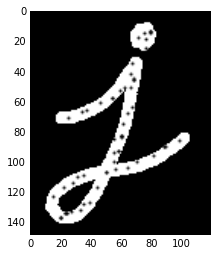

In [14]:
to_close = mpimg.imread('img/morph/closing.png')
plt.imshow(to_close)

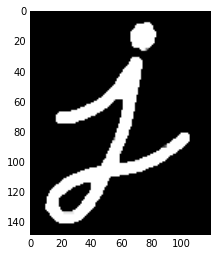

In [15]:
closing = cv2.morphologyEx(to_close, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing)

La función ``cv2.morphologyEx`` permite realizar otras operaciones morfológicas, sin embargo estas se encuentran fuera del alcance del presente tutorial, si desea conocer más, el [tutorial oficial de OpenCV para Python](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#morphological-ops) ofrece otros ejemplos.

## Eliminación de ruido
Empleando operaciones morfológicas, se eliminará el ruido presente en la máscara de detección de las naranjas obtenida previamente:

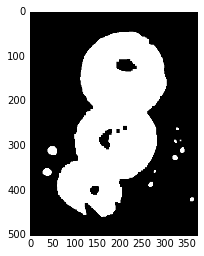

In [16]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(4, 4))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(7, 7))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
plt.imshow(mask, cmap='gray')

Ahora, es posible extraer las naranjas detectadas por el sencillo detector de colores implementado hasta el momento, para este fin se empleará la función ``cv2.bitwise_and``:

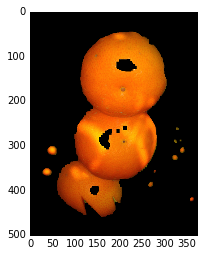

In [17]:
res = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(res)

## Detección de contornos
Ahora nos encontramos interesados en extraer información de la máscara obtenida previamente, y de forma específica, resulta interesante extraer cada una de las naranjas o agrupaciones de naranjas presentes en la imagen, con el fin de contarlas y determinar su posición en la imagen. Debido a que cada naranja se encuentra descrita como una región en la máscara, se procede a encontrar cada una de estas regiones. 

En OpenCV, la detección de contornos (fronteras de las regiones) se realiza empleando la función ``cv2.findContours``, esta función recibe una imágen por parámetro (Binaria), un modo de detección de representación jerárquica y un modo de representación. Con respecto al modo de representación, este se distingue a partir del uso de las constantes ``cv2.CHAIN_APPROX_NONE`` y ``cv2.CHAIN_APPROX_SIMPLE``, mientras el primer modo retorna todos los puntos que conforman la frontera de un contorno, el segundo modo simplifica el número de puntos necesarios para representar el contorno. _e.g.,_ La frontera de un rectángulo puede ser representada usando 4 puntos.

A continuación se presenta la detección de contornos sobre la máscara presentada previamente.

**Nota:** La función ``findContours`` daña la imagen original, así que si se desea conservar una copia de la máscara original, es posible emplear la función ``numpy.ndarray.copy()`` 

In [18]:
mask_original = mask.copy()  # Se guarda una copia de la máscara
_, contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print("Se detectaron: {0} contornos".format(len(contours)))

Se detectaron: 16 contornos


Como es posible apreciar, la función retorna tres argumentos, el primero corresponde a la máscara modificada tras la operación, el segundo corresponde a una lista de contornos detectados en la máscara, finalmente, la función establece una jerarquía entre los contornos detectados, objeto de discusión de la siguiente sección. 

Por el momento, es posible visualizar los contornos detectados usando la función ``cv2.drawContours``, la cual permite definir un color y un radio de contorno. Al igual que la función de detección, esta función modifica la imagen inicial: 

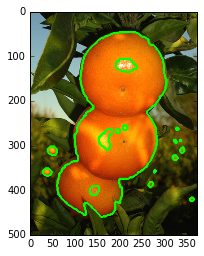

In [19]:
img_contours = img.copy()
img_contours = cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 3)
plt.imshow(img_contours)

Si se desea, es posible dibujar un único contorno en la imagen, empleando el tercer argumento de la función (Inicializado en -1), o envolviendo la lista de puntos dentro de otra lista, como se presenta a continuación:

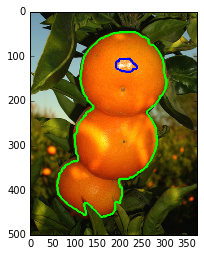

In [20]:
img_contours = img.copy()

cnt = contours[10]
img_contours = cv2.drawContours(img_contours, [cnt], -1, (0, 255, 0), 3) # Se dibuja el contorno número 11
img_contours = cv2.drawContours(img_contours, contours, 15, (0, 0, 255), 3) # Se dibuja el contorno número 16 

plt.imshow(img_contours)

## Jerarquía de contornos
Como fue posible observar en las últimas dos imágenes, los contornos detectados no solo contenían las regiones de interés presentes en las máscaras de umbralización por colores, pero también contienen las regiones contenidas al interior de las mismas, _e.g.,_ Las regiones residuales presentes al interior de la región de mayor tamaño. Sin embargo, estos contornos se encuentran contenidos al interior de otro contorno. 

Hasta el momento, con la información procesada, no es posible establecer de forma directa si un contorno se encuentra contenido al interior de otro. No obstante, la función ``cv2.findContours``, además de los contornos detectados, retorna otro parámetro adicional, el cual corresponde a la relación jerárquica entre los mismos. De acuerdo al modo de detección escogido, es posible obtener una mayor o menor información acerca de los contornos presentes en la imagen.

En el presente caso, se distinguirán dos modos principales de jerarquía, el primer modo (``cv2.RETR_TREE``), establece un árbol de jerarquías sobre todos los contornos presentes en la imagen. Por el contrario, el modo ``cv2.RETR_EXTERNAL``, retorna únicamente los contornos de mayor jerarquía. Por ejemplo, en la imágen que contiene las naranjas, los contornos contenidos al interior de la región de mayor tamaño son rechazados bajo el segundo modo, mientras que bajo el primer modo se conservan, como fue posible observar.

A continuación observaremos la diferencia entre ambos modos:

In [21]:
hierarchy  # cv2.RETR_TREE

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [ 4,  2, -1, -1],
        [ 5,  3, -1, -1],
        [ 6,  4, -1, -1],
        [ 7,  5, -1, -1],
        [ 8,  6, -1, -1],
        [ 9,  7, -1, -1],
        [10,  8, -1, -1],
        [-1,  9, 11, -1],
        [12, -1, -1, 10],
        [13, 11, -1, 10],
        [14, 12, -1, 10],
        [15, 13, -1, 10],
        [-1, 14, -1, 10]]], dtype=int32)

La notación empleada por OpenCV para representar la jerarquía de contornos corresponde a **[Siguiente, Anterior, Primer Hijo, Padre]**, en el ejemplo presentado arriba, es posible notar que existen 11 contornos que se encuentran en el nivel superior, estos se distinguen debido a que el número de su contorno padre corresponde a -1, asímismo, es posible observar que el último nodo que se encuentra en la jerarquía general no cuenta con nodo siguiente (-1). Finalmente, es posible observar que los nodos 12 - 16 se encuentran contenidos al interior del nodo 11.

Ahora, se procede a realizar la detección de contornos usando el modo ``cv2.RETR_EXTERNAL``:

In [22]:
mask = mask_original.copy()
_, contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print("Se detectaron: {0} contornos".format(len(contours)))

Se detectaron: 11 contornos


In [23]:
hierarchy

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [ 4,  2, -1, -1],
        [ 5,  3, -1, -1],
        [ 6,  4, -1, -1],
        [ 7,  5, -1, -1],
        [ 8,  6, -1, -1],
        [ 9,  7, -1, -1],
        [10,  8, -1, -1],
        [-1,  9, -1, -1]]], dtype=int32)

En este caso, es posible apreciar que los contornos contenidos al interior de la región de mayor tamaño son descartados:

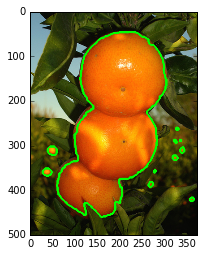

In [24]:
img_contours = img.copy()
img_contours = cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 3)
plt.imshow(img_contours)

## Operaciones sobre contornos
Tras obtener un conjunto de contornos, es posible obtener mayor información geométrica y espacial de interés en una aplicación en específico, entre las operaciones de interés se encuentran:
* Calcular el área/perímetro del contorno
* Encontrar el centro de masa (Centroide)
* Definir un rectángulo/círculo/elipse envolente
* Determinar la relación de aspecto

A continuación se demostrará el funcionamiento de cada una de estas funciones, empleando el contorno de mayor área:

### Área
Para encontrar el área de un contorno, se emplea la función ``cv2.contourArea``. En este caso, se procede a encontrar el contorno que presenta la mayor área:

In [25]:
max_cnt, max_area = None, 0
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > max_area:
        max_cnt, max_area = cnt, area

print("Área de mayor tamaño: {0}".format(max_area))

Área de mayor tamaño: 62741.5


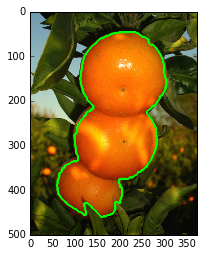

In [26]:
img_contours = img.copy()
img_contours = cv2.drawContours(img_contours, [max_cnt], -1, (0, 255, 0), 3)
plt.imshow(img_contours)

### Perímetro
De forma similar a la función ``cv2.contourArea``, la función ``cv2.arcLength`` permite calcular el perímetro de un contorno:  

In [27]:
perimeter = cv2.arcLength(max_cnt, True)  # El último parámetro indica que es una curva cerrada
print("Perímetro: {0}".format(perimeter))

Perímetro: 1309.56052363


### Momentos y centroides
Para calcular el centroide de un objeto, es necesario calcular sus momentos, esta representación otorga información acerca del área, los centroides y otros. Para mayor información, consultar el artículo de Wikipedia relacionado con los Momentos de una imagen: https://en.wikipedia.org/wiki/Image_moment

A través de la función ``cv2.moments``, OpenCV retorna un diccionario que contiene cada uno de los momentos de la imagen. En este caso resultan de interés los momentos $M_{00}$ (Área), $M_{01}$ y $M_{10}$, los cuales se relacionan con el cálculo del centro de masa $(c_x, c_y)$ de un objeto, a través de la relación:

$$
c_x = \frac{M_{10}}{M_{10}} \qquad c_y = \frac{M_{01}}{M_{10}}
$$

Ahora, calculemos y visualicemos el centro de masa del contorno de mayor área en la imagen:

In [28]:
moments = cv2.moments(max_cnt)
c_x = moments['m10']/moments['m00']
c_y = moments['m01']/moments['m00']

print("Centro de masa: ({0}, {1})".format(c_x, c_y))

Centro de masa: (187.016554699, 245.187534035)


Para visualizar el centro de masa, es posible emplear la función ``cv2.circle``:

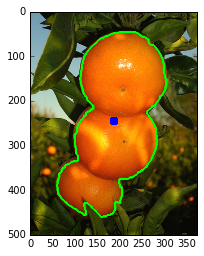

In [29]:
# cv2.circle(img, center, radius, color, line_width → -1 if filled)

cv2.circle(img_contours, (int(c_x), int(c_y)), 10, (0, 0, 255), -1)
plt.imshow(img_contours)

### Envolventes
En ocasiones, se desea aproximar el contorno a través de otras figuras parametrizables (sencillas), tales como rectángulos, círculos y elipses, para este fin, OpenCV ofrece distintas funciones de ajuste, como se presentan a continuación:

#### Envolvente rectangular
Se ajusta un rectángulo recto sobre el contorno a través de la función ``cv2.boundingRect``:

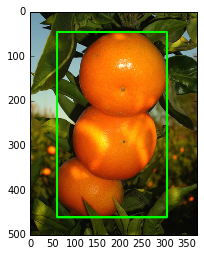

In [30]:
img_rect = img.copy()

x, y, w, h = cv2.boundingRect(max_cnt) # Esquina superior (x, y), ancho (w) y alto (h)

# cv2.rectangle(img, upper_corner, lower_corner, color, line_width → -1 if filled)
cv2.rectangle(img_rect, (x, y), (x + w, y + h), (0, 255, 0), 3)
plt.imshow(img_rect)

También es posible ajustar un rectángulo con rotación al contorno (``cv2.minAreaRect``):

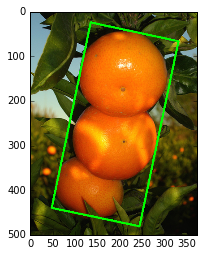

In [31]:
img_rect = img.copy()

rect = cv2.minAreaRect(max_cnt)
box = cv2.boxPoints(rect) # Se obtienen las 4 coordenadas del rectángulo
box = np.int0(box) # Deben ser enteras

cv2.drawContours(img_rect, [box], 0, (0,255,0), 3)
plt.imshow(img_rect)

### Envolvente circular

De forma análoga, es posible proponer envolventes circulares usando la función ``cv2.minEnclosingCircle``:

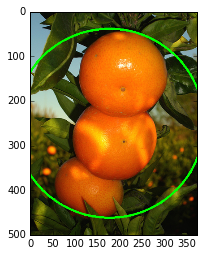

In [32]:
img_circ = img.copy()

(x, y), radius = cv2.minEnclosingCircle(max_cnt) # Retorna el centro del círculo y su radio
center = (int(x), int(y)) # Los parámetros deben ser enteros
radius = int(radius)

cv2.circle(img_circ, center, radius, (0, 255, 0), 3)
plt.imshow(img_circ)

### Elipse ajustada
También es posible ajustar elipses a un contorno (``cv2.fitEllipse``):

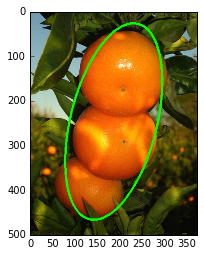

In [33]:
img_ell = img.copy()

ellipse = cv2.fitEllipse(max_cnt)

cv2.ellipse(img_ell, ellipse, (0, 255, 0), 3) # Dibuja una elipse
plt.imshow(img_ell)

## Umbralización y detección de bordes
La mayor parte del tiempo, se desean implementar aplicaciones de detección y seguimiento en las cuales no es posible definir un objeto de interés únicamente por su color. En este caso, es necesario umbralizar la imágen de entrada a través de otras técnicas, con el objetivo de detectar las regiones, contornos y eventualmente otras propiedades sobre los mismos. Para este fin, OpenCV ofrece la función ``cv2.threshold``, la cual permite umbralizar una imagen a partir de diferentes técnicas. Por ejemplo, consideremos la siguiente imagen:

### Umbralización (Thresholding)

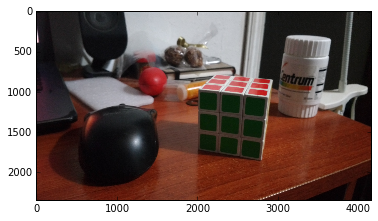

In [34]:
img = mpimg.imread('img/thresholding/sample.jpg')
plt.imshow(img)

A continuación se procede a umbralizar la imagen empleando uno de los métodos adaptativos ofrecidos por OpenCV, debido a que la imagen presenta diferentes condiciones de iluminación:

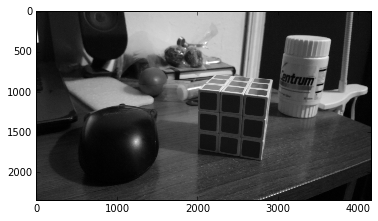

In [35]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Se emplea la representación en escala de grises
gray = cv2.medianBlur(gray, 5) # Se difumina la imagen para reducir el ruido
plt.imshow(gray, cmap='gray')

Se umbraliza la imagen:

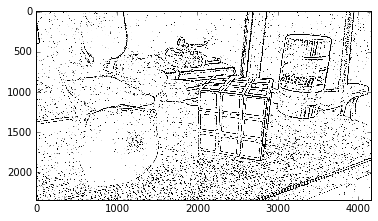

In [36]:
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY,11,2)

plt.imshow(thresh, cmap='gray')

Existen otros métodos de umbralización, tal como la binarización de Otsu.

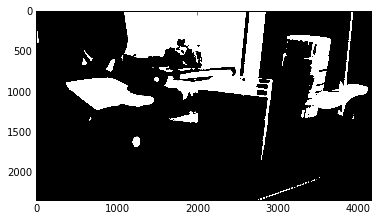

In [37]:
ret3, th3 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th3, cmap='gray')

Tras umbralizar, es posible emplear cada una de las funciones presentadas al inicio del presente módulo.

Para mayor información acerca de los métodos de umbralización disponibles, visitar la sección de [Umbralización](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html#thresholding) de los tutoriales oficiales de OpenCV.

### Detección de bordes
En otras ocasiones, resulta de interés detectar los bordes presentes en una imagen, ya sea para segmentar un objeto en particular, o por efectos gráficos. Para lograr este objetivo, OpenCV ofrece diversas aproximaciones, desde emplear el gradiente de una imagen, así como detectores de bordes más refinados como Canny. Al igual que las regiones umbralizadas, los bordes pueden ser empleados para detectar contornos.

**Fuentes adicionales:** Para obtener mayor información técnica relacionada con este tema, se recomienda revisar la guía en [detección de bordes y gradientes](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html#gradients) de OpenCV

#### Gradiente de una imagen
Debido a que una imagen puede ser comprendida como una función de dos dimensiones (Escala de grises), ésta puede ser derivable, lo cual implica que existe la noción de gradiente en términos de la dirección del cambio en los valores de intensidad en cada píxel. A partir de esta definición, es posible observar que los bordes se encuentran en las regiones de mayor cambio en el gradiente de la imagen, y por lo tanto, el gradiente de la imagen resalta los bordes de una imagen:

In [38]:
dx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)  # Derivada en x
dy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)  # Derivada en y

grad = np.sqrt(dx**2  + dy**2) # Magnitud del gradiente

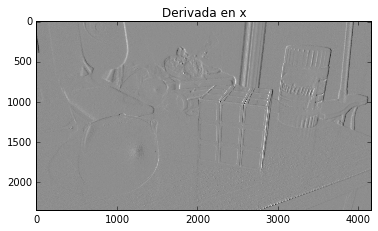

In [39]:
plt.imshow(dx, cmap='gray')
plt.title('Derivada en x')

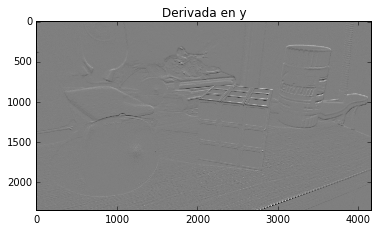

In [40]:
plt.imshow(dy, cmap='gray')
plt.title('Derivada en y')

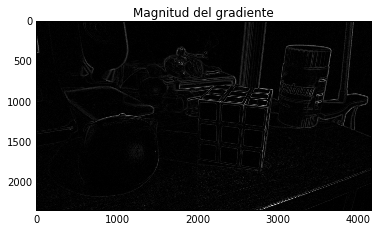

In [41]:
plt.imshow(grad, cmap='gray')
plt.title('Magnitud del gradiente')

#### Métodos avanzados
Existen otros métodos que refinan la información de bordes obtenidas a partir del gradiente, entre los métodos históricos más reconocidos, se encuentra el detector de bordes de Canny, el cual permite eliminar regiones que presentan ruido y que no representan bordes formalmente. Es posible invocar el detector de Canny a través de la función ``cv2.Canny``: 

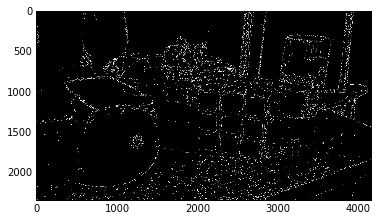

In [46]:
edges = cv2.Canny(gray, 4, 30) # Umbral de detección de bordes entre 4 y 30 (Magnitud de gradiente)

plt.imshow(edges, cmap='gray')

# Ejercicio
Ha llegado la hora de aplicar todo el conocimiento básico relacionado con extracción de contornos y procesamiento de imágenes básico. Para este fin, se propone realizar una tarea bastante interesante e interactiva, implementar un juego de Pong controlado a través de un objeto de color, en este caso, las imágenes serán capturadas directamente desde la cámara conectada al computador, a través del módulo ``pygame.camera``, el esqueleto de funcionamiento básico se encuentra bajo la carpeta ``pong/camera_basic.py``, por favor, verificar que este permite capturar y visualizar imágenes extraidas desde la cámara.

## 1. Encontrar el centroide de un objeto de un color específico
A partir de las imágenes capturadas desde la cámara, y un objeto de color distintivo que tenga a la mano, determinar su posición en la cámara a partir del centro de masa. Para este fin, escribir una función ``threshold_object_color`` que cumpla con la siguiente especificación, la función recibe una imagen (RGB) como parámetro, y un par de rangos de colores en el espacio HSV, estos valores deben ser definidos de acuerdo al color del objeto.
```python
def threshold_object_color(img, upper_color, lower_color):
    c_x, c_y = 0, 0 # Coordenadas del centroide
    try:
        # Escribir el código aquí
        c_x, c_y = ... # Coordenadas del centroide
    except Exception:
        pass
    return (c_x, c_y)
```

## 2. Probar la función en pygame

Probar que al acercar el objeto a la camara, el centroide del objeto sea dibujado

## 3. Invocar una instancia del objeto Pong

Esta se encuentra definida en el módulo ``pong/pong.py``, y toma por parámetro el ``screen`` de pygame, así como las dimensiones de la ventana:

```python
pong_game = Pong(screen, w, h)
```

## 4. Invocar el método de juego de la instancia
La función ``Pong.play`` recibe como parámetro las coordenadas del centroide, a través del argumento ``player1``, _i.e.,_
```python
pong_game.play(player1=centroide)
```

## 5. Enjoy
Probar que el juego funciona, e intentar ganarle a la máquina (Si es que es posible, muahahaha)